In [43]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
import pdb

print("tf version", tf. __version__)

tf version 2.12.0


In [44]:
# Set the working directory
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [45]:
# Set seed
seed = 42
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  # tf.experimental.numpy.random.seed(seed)
  # tf.compat.v1.get_seed(seed)
  # tf.compat.v1.set_random_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['CUDA_VISIBLE_DEVICES'] = " "
set_seed(42)

# from keras import backend as K
# session_conf = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)
# #Force Tensorflow to use a single thread
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

tf.config.experimental.enable_op_determinism()

In [46]:
# Load dataset
csv_path = os.getcwd() + '/SOCwithMODIS3927.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df = df.drop(columns=['latitude', 'longitude', 'year', 'LC'])
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2-1,SR_B3-1,SR_B4-1,SR_B5-1,...,SR_B5,SR_B6,SR_B7,EVI,ST_B10,VV,VH,VV/VH,prec,temp
0,6.84225,1641,1.311631,47.303562,15.660496,-0.83046,0.166671,0.1916,0.207811,0.371354,...,0.421857,0.312834,0.240069,0.20156,278.537831,0.100637,0.016779,5.997724,7.733378,15284.333333
1,5.94385,1634,5.549156,61.341667,12.340887,-1.442346,0.372605,0.421583,0.433325,0.565792,...,0.317,0.238625,0.19193,0.208251,278.115705,0.081446,0.023201,3.510426,7.733378,15268.8
2,4.4506,1626,5.39333,63.41954,13.694862,-1.242844,0.27762,0.305148,0.311541,0.404409,...,0.309575,0.20645,0.191408,0.178394,279.735847,0.077992,0.012462,6.258336,7.733378,15268.8
3,7.10625,1652,1.854871,54.527138,8.628444,-1.174888,0.367902,0.366472,0.369855,0.448093,...,0.403735,0.277304,0.221039,0.216093,276.727989,0.066324,0.01395,4.754431,7.733378,15284.333333
4,7.06505,1629,3.340624,22.484619,12.107599,1.348318,0.242035,0.272423,0.284,0.40731,...,0.373843,0.288648,0.22812,0.184308,274.041426,0.073882,0.013287,5.560403,7.733378,15284.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,22.8393,707,20.518735,0.136192,106.600021,-2.546244,0.62742,0.59519,0.589608,0.635175,...,0.421184,0.306385,0.235765,0.261945,277.474827,0.064739,0.018256,3.546261,12.289015,14907.5
3922,30.57,699,38.66111,340.387939,109.372704,2.081008,0.485355,0.504633,0.530978,0.598903,...,0.319393,0.191036,0.150501,0.202044,278.725822,0.109743,0.024399,4.497798,12.289015,14909.0
3923,15.9412,806,17.840438,64.873627,90.641815,-1.627684,0.518616,0.507094,0.506846,0.557446,...,0.414515,0.286392,0.209832,0.309452,279.137693,0.055422,0.013671,4.053926,12.289015,14909.0
3924,54.9658,880,26.979864,238.814835,104.778091,-3.461416,0.515701,0.516458,0.519826,0.58507,...,0.390535,0.29786,0.254437,0.27747,278.084943,0.261001,0.054931,4.751455,12.289015,14907.5


In [64]:
df = df[['SOC', 'elev', 'slope', 'aspect', 'roughness', 'twi', 'SR_B2',
       'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI', 'VV',
       'VH', 'VV/VH', 'prec', 'temp']]
df['temp'] = df['temp']*0.02
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,VV,VH,VV/VH,prec,temp
1139,6.6546,237,2.073037,33.096291,3.61566,0.379663,0.227776,0.299744,0.327464,0.414185,0.407516,0.334339,0.128492,0.046457,0.011828,3.92784,0.365554,6.262933
3517,1.96765,638,6.1857,275.47818,14.379381,2.981755,0.43679,0.449275,0.463108,0.586459,0.451434,0.355376,0.186925,0.063735,0.014042,4.538879,5.6155,6.011467
2061,8.3373,1131,2.077033,141.048462,1.111075,1.407584,0.18984,0.190995,0.228642,0.339055,0.321125,0.250835,0.161097,0.05592,0.010726,5.213368,4.476007,6.110933
2386,5.4168,50,2.780289,141.564209,0.476748,0.19605,0.191242,0.22834,0.285045,0.44493,0.329182,0.25254,0.198099,0.041074,0.006702,6.128891,0.053697,6.2384
2195,12.4365,1226,2.073041,95.474571,5.300976,-0.143577,0.045162,0.116937,0.1201,0.406485,0.2048,0.159397,0.35623,0.107281,0.025417,4.220827,19.584442,6.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,7.599,1048,2.930743,165.189835,0.543041,6.265418,0.189579,0.241856,0.279985,0.353451,0.367806,0.313411,0.094787,0.02399,0.00357,6.720506,1.034605,6.2852
2406,4.8924,31,6.338529,346.405029,5.235198,-0.507171,0.094415,0.184477,0.21668,0.389847,0.26915,0.225837,0.190793,0.032417,0.004162,7.789418,0.161697,6.2327
794,6.8069,954,2.780289,5.38974,7.17576,2.319533,0.071563,0.12593,0.152454,0.269219,0.237841,0.203384,0.154354,0.116184,0.036157,3.213331,2.524749,6.2294
2331,4.4062,27,4.235498,111.467102,11.644985,-1.692325,0.34021,0.3577,0.364163,0.448505,0.23505,0.201582,0.212763,0.113322,0.017269,6.562227,0.1647,6.2124


In [65]:
# Shuffle and scale the data
df = df.sample(frac=1, random_state=42)
scaler = MinMaxScaler()
n = len(df)

train_df = scaler.fit_transform(df[0:int(n*0.8)])
val_df = scaler.transform(df[int(n*0.8):int(n*0.9)])
test_df = scaler.transform(df[int(n*0.9):])
# train_df = scaler.fit_transform(df[:11760])
# val_df = scaler.transform(df[11760:(11760+1464)])
# test_df = scaler.transform(df[(11760+1464):])

Xtrain = train_df[:,1:]
Ytrain = train_df[:,0]

Xval = val_df[:,1:]
Yval = val_df[:,0]

Xtest = test_df[:,1:]
Ytest = test_df[:,0]

# Reshape it to be (n_data, time_step, feature)
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xval = np.reshape(Xval, (Xval.shape[0], 1, Xval.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

# Reshape it to be (n_data, time_step)
Ytrain = np.reshape(Ytrain, (Ytrain.shape[0], 1))
Yval = np.reshape(Yval, (Yval.shape[0], 1))
Ytest = np.reshape(Ytest, (Ytest.shape[0],1))

In [50]:
# Show metadsata of the dataset
df.apply(['mean', 'median', 'max', 'min', 'std', 'skew', 'count']).transpose()

,mean,median,max,min,std,skew,count
SOC,10.463713,7.863617,119.511800,1.161600,9.776697,4.022503,3926.0
elev,829.683902,949.500000,2022.000000,-3.000000,511.701796,-0.230890,3926.0
slope,4.926067,2.796733,44.899754,0.000000,6.428781,2.887663,3926.0
aspect,172.492233,166.017647,359.977112,0.032219,107.046876,0.116194,3926.0
roughness,15.216692,5.734655,201.859283,0.215358,25.439797,2.995559,3926.0
twi,0.406410,0.081835,10.531526,-3.988649,2.122389,1.167213,3926.0
SR_B2,0.203352,0.163811,0.900811,0.005604,0.145114,1.152982,3926.0
SR_B3,0.251021,0.216164,0.841260,0.038315,0.125415,1.142107,3926.0
SR_B4,0.271416,0.239615,0.853401,0.031935,0.125701,1.028487,3926.0
SR_B5,0.414502,0.405983,0.857114,0.200359,0.100556,0.675068,3926.0


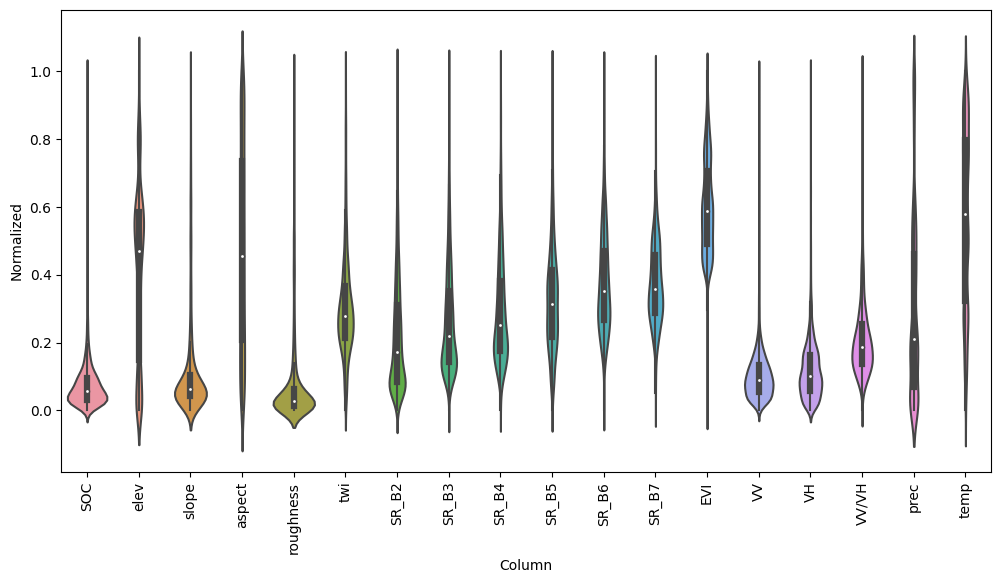

In [51]:
# Show the value ranes of the dataset
df_std = pd.DataFrame(train_df).melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
# Hyperparameter tuning using validation dataset
initializer = tf.keras.initializers.GlorotUniform(seed=42)
batch_size = [128, 256]
units = [32, 64, 128, 256]
units_dense = 1
lr = [0.05, 0.01, 0.005]
epochs = 200
info = pd.DataFrame(columns=['batchsize', 'unit', 'learningrate', 'model', 'rmse', 'r2'])
i = 0

for batchSize in batch_size:
    for unit in units:
        for learningRate in lr:

            model1 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])
            
            model2 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])

            model3 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/4), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')
            ])

            model4 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=Xtrain.shape[1:], return_sequences=True, kernel_initializer=initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/4), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/8), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')
            ])
            
            for j in range(4):
                model = [model1, model2, model3, model4][j]
                
                print(i)

                model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
                    metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.RootMeanSquaredError()
                            ])

                # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
                early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

                history = model.fit(Xtrain, Ytrain, 
                                    epochs=epochs, 
                                    batch_size=batchSize,
                                    validation_data=(Xval, Yval), 
                                    callbacks=[early_stopping]
                                    )
                Ypred = model.predict(Xval)
                Ypred=np.reshape(Ypred, Yval.shape)
                mse = mean_squared_error(Yval, Ypred)
                print("RMSE", math.sqrt(mse))
                mae = mean_absolute_error(Yval, Ypred)
                print("MAE", mae)
                R_square = r2_score(Yval, Ypred) 
                print('Coefficient of Determination', R_square) 

                addCol = pd.Series( [ batchSize, unit, learningRate, str(j+1), math.sqrt(mse), R_square ],
                       index=info.columns 
                       )
                
                info.loc[i] = addCol

                i=i+1

print(info)
info.to_csv(os.getcwd() + '/info.csv', index=False)

In [ ]:
# Define the potential best model and its hyperparameters
batch_size = 128
unit = 64
units_dense = 1
lr = 0.01
epochs = 200
model = model2

In [54]:
# See the model details
print('train data size', len(train_df))
model.summary()

train data size 3140
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 64)                20992     
                                                                 
 batch_normalization_120 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 dropout_120 (Dropout)       (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21,313
Trainable params: 21,185
Non-trainable params: 128
_________________________________________________________________
None
Model: "sequential_49"
________________________________________________________________

In [70]:
# Train the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                       tf.keras.metrics.RootMeanSquaredError()
                       ])

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(Xtrain, Ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(Xval, Yval), 
                    callbacks=[early_stopping]
                    )

Epoch 1/1000


2023-06-20 10:38:20.021896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3140,1]
	 [[{{node Placeholder/_11}}]]
2023-06-20 10:38:20.022249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3140,1]
	 [[{{node Placeholder/_11}}]]
2023-06-20 10:38:20.296201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

25/25 [==============================] - ETA: 0s - loss: 0.7805 - mean_absolute_error: 0.6269 - root_mean_squared_error: 0.8835

2023-06-20 10:38:25.436152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [393,1]
	 [[{{node Placeholder/_11}}]]
2023-06-20 10:38:25.436511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [393,1]
	 [[{{node Placeholder/_11}}]]
2023-06-20 10:38:25.719907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

25/25 [==============================] - 6s 57ms/step - loss: 0.7805 - mean_absolute_error: 0.6269 - root_mean_squared_error: 0.8835 - val_loss: 0.0067 - val_mean_absolute_error: 0.0630 - val_root_mean_squared_error: 0.0821
Epoch 2/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.1640 - mean_absolute_error: 0.3005 - root_mean_squared_error: 0.4050 - val_loss: 0.0063 - val_mean_absolute_error: 0.0450 - val_root_mean_squared_error: 0.0793
Epoch 3/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0819 - mean_absolute_error: 0.2136 - root_mean_squared_error: 0.2862 - val_loss: 0.0056 - val_mean_absolute_error: 0.0517 - val_root_mean_squared_error: 0.0751
Epoch 4/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0420 - mean_absolute_error: 0.1495 - root_mean_squared_error: 0.2051 - val_loss: 0.0053 - val_mean_absolute_error: 0.0470 - val_root_mean_squared_error: 0.0731
Epoch 5/1000
25/25 [==============================] - 0s 14ms/ste

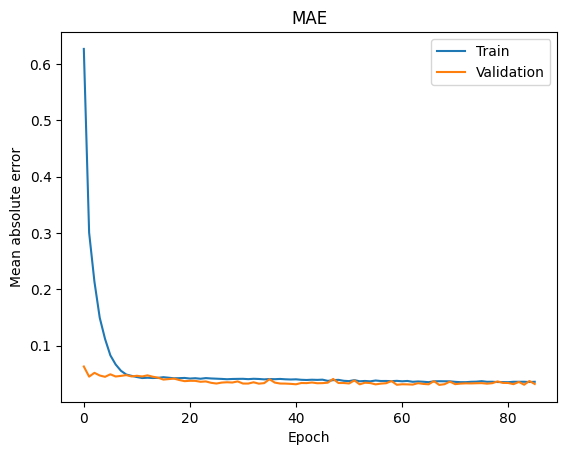

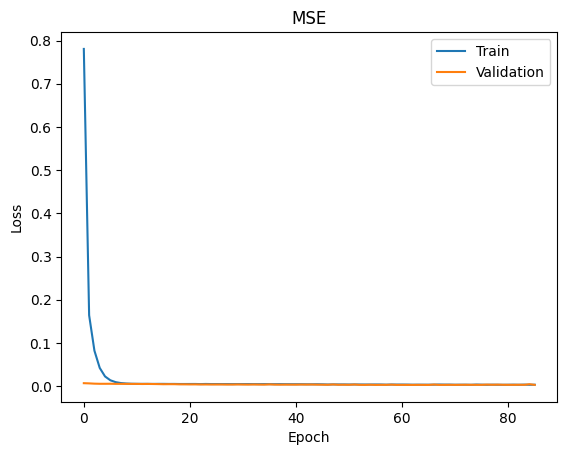

In [71]:
# Plot the training and validation accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [72]:
# Predict SOC using test dataset
Ypred = model.predict(Xtest)
Ypred = np.reshape(Ypred, Ytest.shape)
Ypred = scaler.inverse_transform(Ypred)
print('shape', Ypred.shape)
print(Ypred[:10], np.max(Ypred), np.min(Ypred))

2023-06-20 10:39:03.696298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [393,1,17]
	 [[{{node Placeholder/_10}}]]
2023-06-20 10:39:03.696614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [393,1,17]
	 [[{{node Placeholder/_10}}]]
2023-06-20 10:39:03.966804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

13/13 [==============================] - 1s 4ms/step
shape (393, 1)
[[0.13312495]
 [0.16519153]
 [0.09766502]
 [0.08723585]
 [0.10430825]
 [0.04376319]
 [0.08572116]
 [0.0397332 ]
 [0.05901792]
 [0.13968942]] 0.59293646 0.027046673


In [73]:
# Calculate the metric values
mse = mean_squared_error(Ytest, Ypred)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ytest, Ypred)
print("MAE", mae)
R_square = r2_score(Ytest, Ypred) 
print('Coefficient of Determination', R_square) 

RMSE 0.06550594222488867
MAE 0.03509524342463986
Coefficient of Determination 0.5560301997636796


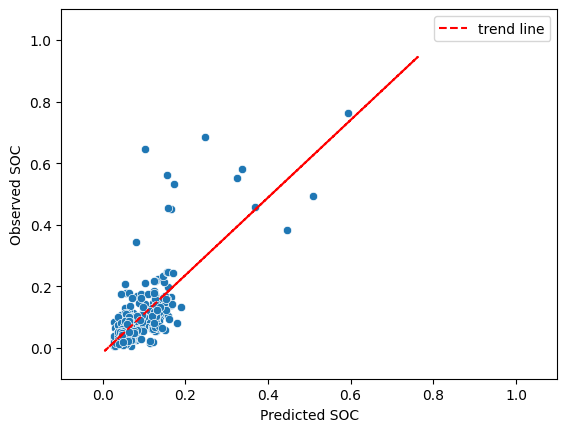

In [74]:
# Plot the predicted SOC against the observed SOC
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

In [ ]:
# Save the trained model
model.save(os.getcwd() + '/LSTM', save_format='tf')

In [ ]:
# Check if the model can be properly loaded
model = tf.keras.models.load_model(os.getcwd() + '/LSTM') 